# Uplift Modeling Evaluation

*Author: Chris Barton* 

In this notebook, we look at how to evaluate an uplift model. This is trickier than evaluating a traditional supervised learning model as we don't know the ground truth, that is, we don't know the outcome of the target variable had we taken a different action. For this reason, traditional metrics like RMSE and accuracy don't make a ton of sense. 

To begin exploration of this topic, we will import some data and look at the average treatment effect for the control and test population. 

In [28]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from IPython.display import clear_output
from scipy import stats
%matplotlib inline
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
client = bigquery.Client()

query_job = client.query("""
       SELECT f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11, treatment, conversion 
       FROM `uplift.data` b 
       ORDER BY RAND() 
       LIMIT 1000000
    """)

df = query_job.to_dataframe()

### Average Treatment Effect (ATE)

In [4]:
base = df[df.treatment == 0]
variant = df[df.treatment == 1]
    
delta = variant.conversion.mean() - base.conversion.mean()

delta_err = 1.96 * np.sqrt(variant.conversion.var() / variant.shape[0] + base.conversion.var() / base.shape[0])
  
print("Control: %s, N = %s, Rate: %s" % ( df[df.treatment == 0]['conversion'].sum() 
                               , df[df.treatment == 0].shape[0]
                               , df[df.treatment == 0]['conversion'].sum() / float(df[df.treatment == 0].shape[0]
     )))

print("Test: %s, N = %s, Rate: %s" % (df[df.treatment == 1]['conversion'].sum()
                            , df[df.treatment == 1].shape[0]
                            , df[df.treatment == 1]['conversion'].sum() / float(df[df.treatment == 1].shape[0]
     )))

print("")
print("estimated_effect %s, standard_error: %s" % (delta, delta_err))
print("")
lift = (variant.conversion.mean() - base.conversion.mean()) / base.conversion.mean()
print("Lift: %s" % lift)
print("")
t = stats.ttest_ind(df[df.treatment == 1]['conversion'], df[df.treatment == 0]['conversion'])
print("Test Statistic: %s, P-Value: %s" % (t[0], t[1]))

Control: 273, N = 153885, Rate: 0.001774052051856906
Test: 1995, N = 846115, Rate: 0.0023578355188124548

estimated_effect 0.0005837834669555487, standard_error: 0.00023428472665056992

Lift: 0.32906783447785576

Test Statistic: 4.428330040575782, P-Value: 9.49755531677034e-06


### ATE: Results 

Above, we can see there is a difference in conversion rate between the control and test, resulting in a 33% lift in conversion. Albeit, the conversion rate is very low at .17% and .23% for control and test, respectively. 

Now that we have established that there is a difference is test and control conversion rates, we can proceed with Uplift Modeling. 

Moving forward, we will build a model to predict conversion on the treatment dataset. We will use under sampling to balance the outcome class during training. 

In [6]:
# subset dataset and train model. 
X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']][df.treatment == 1], df['conversion'][df.treatment == 1], test_size=0.33, random_state=35)

spw=(y_train.shape[0] - y_train.sum()) / y_train.sum()

# train model with balanced dataset 
treatment_model = xgboost.XGBClassifier(scale_pos_weight=spw)
treatment_model.fit(X_train, y_train)

y_pred = treatment_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.28%


In [13]:
treatment_results               = pd.DataFrame(y_test)
treatment_results['treatment']  = 1
treatment_results['prob']       = treatment_model.predict_proba(X_test)[:,1]
treatment_results['prediction'] = treatment_model.predict(X_test)
treatment_results.head()

,conversion,treatment,prob,prediction
91754,0,1,0.134870,0
308249,0,1,0.311785,0
1073,0,1,0.047511,0
782374,0,1,0.046478,0
110369,0,1,0.012314,0


## Gain Curve

Before we explore Uplift specific evaluation metrics, it is useful to create a gains chart and Gini coefficient, as traditional metrics used in Uplift modeling can be thought of as a generalization of the Gini coefficient. 

In the treatment_results dataframe, we have four columns:
    - Conversion
    - Treatment
    - Probability of conversion
    - Prediction (binary)
    
To create a gains chart we follow a few simple steps:

1. Sort by probability of conversion (descending). 
2. Create array for cumulative sum of conversions.
3. Create array for number of users targeted. 
4. Plot targeted users on the Y axis and conversions on the X axis. 


Text(0.5, 1.0, 'Gain Chart')

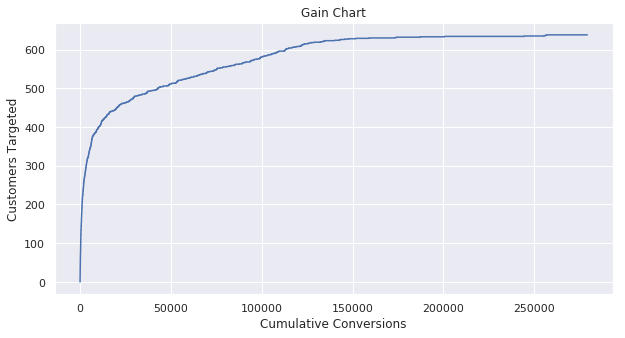

In [14]:
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [10, 5]
treatment_results = treatment_results.sort_values(by=['prob'], ascending=False)
number_purchases = treatment_results['conversion'].cumsum()
number_targeted  = treatment_results['treatment'].cumsum()
plt.plot(number_targeted, number_purchases)
plt.xlabel("Cumulative Conversions")
plt.ylabel("Customers Targeted")
plt.title("Gain Chart")

Now in order to make this chart more intuitive we need to add some perspective. We will do this by graphing a baseline (random) model and a perfect model. 

- Random: This just assigns a random probability of conversion for every row.
- Perfect: This sorts dataframe by conversions, so that every person who converts get targeted before a non-converter. 

Text(0.5, 1.0, 'Gains Chart')

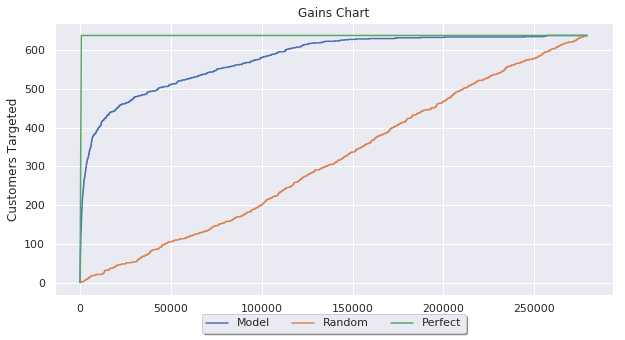

In [15]:
# add random targeting
treatment_results['random_prob'] = [ np.random.random()  for k in treatment_results.index]
treatment_results = treatment_results.sort_values(by=['random_prob'], ascending=False)
rand_number_purchases = treatment_results['conversion'].cumsum()
rand_number_targeted  = treatment_results['treatment'].cumsum()

# add optimal targeting  
treatment_results = treatment_results.sort_values(by=['conversion'], ascending=False)
optimum_number_purchases = treatment_results['conversion'].cumsum()
optimum_number_targeted  = treatment_results['treatment'].cumsum()

plt.plot( number_targeted          ,  number_purchases, label='Model')
plt.plot( rand_number_targeted     ,  rand_number_purchases, label='Random')
plt.plot( optimum_number_targeted  ,  optimum_number_purchases, label='Perfect')
plt.xlabel("Cumulative Conversions")
plt.ylabel("Customers Targeted")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.title("Gains Chart")

The chart above gives us a good visualization of how well are model performs compared to a random and perfect model. This is where the Gini Coefficient comes in. 

### Gini Coefficient

From the gains chart, one defines the Gini coefficient as the ratio between two areas:
- The area above the diagonal line (random model) and the cumulative gains line; 
- The area between the diagonal and the optimum

Below, we will calculate this. 

In [16]:
# https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation

### From Gini to Qini 

Now, using the Gini metric/curve for evaluating an Uplift Modeling doesn't make as much sense as we don't know the true counterfactual outcome. That is, we want to see how well our Uplift model is at predicting uplift, but since we don't know the outcome of the counterfactual (i.e. what somebody would have done given other action), we can't plot this at an individual level. 

However, we can compare segments of the population. For example, we can sort the dataframe by uplift score (descending). Then for each decile in test and control we calculate the number of positive outcomes. We then subtract the number of positive outcomes in treatment minus the number in control. This give us incremental sales or uplift per decile. 

Now let's step back, for a second, and think about why this makes sense. If we sort by uplift and segment test and control populations by decile, the first decile in the test group should have a large number of converters. These are people how we predicted would convert when shown an ad, and since they are in the treatment group they were shown and ad. Furthermore, we would expect the control to have a low number of conversions. We also predicted they'd convert if shown and ad, however they were not shown and ad, so their likelihood of converting is, most likely, very small. Ideally we will see the highest uplift in the first decile, then it should decrease and level off until the last deciles where we could/should see negative uplift. If we see negative uplift (downlift) in segments we are observing what is known as sleeping dogs (customers who will buy without seeing and ad, but will not buy if they do see an ad). 

Below, we will build a model for the control group. We will then subtract the output probabilities of the test model and control model to come up with predicted uplift (two-model approach), after which we will build an Uplift plot. 


In [16]:
# build control model 
Xc_train, Xc_test, yc_train, yc_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']][df.treatment == 0], df['conversion'][df.treatment == 0], test_size=0.33, random_state=35)
spw=(yc_train.shape[0] - yc_train.sum()) / yc_train.sum()

# train model with balanced dataset 
control_model = xgboost.XGBClassifier(scale_pos_weight=spw)
control_model.fit(Xc_train, yc_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=511.9452736318408,
       seed=None, silent=True, subsample=1)

In [17]:
# build test dataframe 
c = pd.concat([Xc_test, yc_test], axis=1)
c['treatment'] = 0
t = pd.concat([X_test, y_test], axis=1)
t['treatment'] = 1
test_df = pd.concat([c, t])

In [18]:
results                         = pd.DataFrame(test_df['conversion'])
results['treatment']            = test_df['treatment']
results['treatment_prob']       = treatment_model.predict_proba(test_df[test_df.columns[:-2]])[:,1]
results['control_prob']         = control_model.predict_proba(test_df[test_df.columns[:-2]])[:,1]
results['treatment_pred']       = treatment_model.predict(test_df[test_df.columns[:-2]]) 
results['control_pred']         = control_model.predict(test_df[test_df.columns[:-2]]) 

In [19]:
results['uplift'] = results['treatment_prob'] - results['control_prob']
results           = results.sort_values(by=['uplift'], ascending=False)
results['random'] = [ np.random.random()  for k in results.index]

In [20]:
control_total   = results[results.treatment == 0].shape[0]
treatment_total = results[results.treatment == 1].shape[0]

uplift_ttl = pd.DataFrame({'segment'      : np.arange(0,1.1, .1)                 ,
                           'control_pop'  : np.arange(0,1.1, .1)*control_total   ,
                           'test_pop'     : np.arange(0,1.1, .1)*treatment_total 
                      })

uplift_ttl['test_pop']      = uplift_ttl['test_pop'].astype(int)
uplift_ttl['control_pop']   = uplift_ttl['control_pop'].astype(int)
uplift_ttl['r_tk']          = uplift_ttl['test_pop'].apply(lambda x: results[results.treatment == 1].sort_values(by=['uplift'], ascending=False)['conversion'][:x].sum())
uplift_ttl['r_ck']          = uplift_ttl['control_pop'].apply(lambda x: results[results.treatment == 0].sort_values(by=['uplift']  , ascending=False)['conversion'][:x].sum())

uplift_ttl['rand_tk']       = uplift_ttl['test_pop'].apply(lambda x: results[results.treatment == 1].sort_values(by=['random'], ascending=False)['conversion'][:x].sum())
uplift_ttl['rand_ck']       = uplift_ttl['control_pop'].apply(lambda x: results[results.treatment == 0].sort_values(by=['random']  , ascending=False)['conversion'][:x].sum())

# for perfect we need to sort by incremental 
uplift_ttl['perfect_tk']    = uplift_ttl['test_pop'].apply(lambda x: results[results.treatment == 1].sort_values(by=['conversion'], ascending=False)['conversion'][:x].sum())
uplift_ttl['perfect_ck']    = uplift_ttl['control_pop'].apply(lambda x: results[results.treatment == 0].sort_values(by=['conversion'] )['conversion'][:x].sum())

uplift_ttl['pract_tk']      = uplift_ttl['test_pop'].apply(lambda x: results[results.treatment == 1].sort_values(by=['conversion'], ascending=False)['conversion'][:x].sum())
uplift_ttl['pract_ck']      = uplift_ttl['control_pop'].apply(lambda x: results[results.treatment == 0].sort_values(by=['conversion'], ascending=False )['conversion'][:x].sum())

# calculate uplift 
uplift_ttl['q']     = uplift_ttl.apply(lambda x: x[3] - x[2] * x[4] / x[0]  , axis=1)
uplift_ttl['rq']    = uplift_ttl.apply(lambda x: x[5] - x[2] * x[6] / x[0]  , axis=1)
uplift_ttl['pq']    = uplift_ttl.apply(lambda x: x[7] - x[2] * x[8] / x[0]  , axis=1)
uplift_ttl['ppq']   = uplift_ttl.apply(lambda x: x[9] - x[2] * x[10] / x[0] , axis=1)

/home/cbartondepaul/Notebooks/env/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/home/cbartondepaul/Notebooks/env/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/cbartondepaul/Notebooks/env/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/home/cbartondepaul/Notebooks/env/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [21]:
uplift_ttl = uplift_ttl.fillna(0)

Text(0.5, 1.0, 'Uplift Chart')

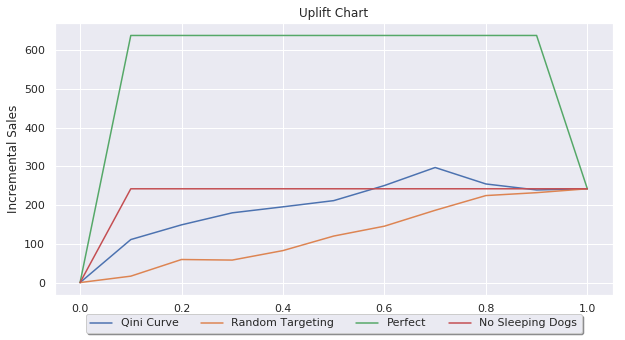

In [27]:
plt.plot(np.arange(0,1.1, .1),  uplift_ttl['q']   , label='Qini Curve')
plt.plot(np.arange(0,1.1, .1),  uplift_ttl['rq']  , label='Random Targeting')
plt.plot(np.arange(0,1.1, .1),  uplift_ttl['pq']  , label='Perfect')
plt.plot(np.arange(0,1.1, .1),  uplift_ttl['ppq'] , label='No Sleeping Dogs')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.xlabel("Fraction of Customers Targeted")
plt.ylabel("Incremental Sales")
plt.title("Uplift Chart")

Similar to the Gini Coeffecient, the Qini coefficient is calculated by taking the ratio of two areas:
1. The area between the random curve and the Qini Curve.
2. The area between the random curve and the perfect curve.
    - As we discuss below, there are two options for the prefect curve. 

The perfect targeting curve can take many different forms. Two are outlined below. 

1. No Negative Effect (No Sleeping Dogs)
    - In this curve, we make the assumption that targeting somebody with an Ad can not have any negative effects i.e. no sleeping dogs. We can see this curve above in the red line. 
2. Negative Effects.
    - In this curve, we make the assume the perfect model, predicts all incremental sales first and puts any negative effects at the end of the model. 


### Additional Metrics

The Qini coefficient and curve have many variants that have been developed overtime. Below we will look at a few common variants and their benefits. 

- Cumulative Gain 

- Adjusted Qini Curve 



## References 

1. The University of Edinburgh School of Mathematics, Testing a New Metric for Uplift Models by Oscar Mesalles Naranjo